# Fitting photometric data with model spectra

In this tutorial, we will fit the photometric data of [beta Pic b](http://exoplanet.eu/catalog/beta_pic_b/) with the synthetic spectra from the [DRIFT-PHOENIX](https://leap2010blog.wordpress.com/2014/07/03/drift-phoenix-atmosphere-models-creating-new-worlds/) atmosphere model.

## Getting started

We start by importing *species* and creating an instance of `SpeciesInit`. This will initiate the HDF5 database and creates a configuration file in the working folder.

In [1]:
import species
species.SpeciesInit()

Initiating species v0.2.0... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


## Adding data to the database

An object of `Database` is created which is used for adding data to the database.

In [2]:
database = species.Database()

The DRIFT-PHOENIX spectra are added. We restrict the wavelength range and spectral resolution such that reading from the database will be faster.

In [3]:
database.add_model(model='drift-phoenix',
                   wavel_range=(0.8, 6.),
                   spec_res=1000.)

Unpacking DRIFT-PHOENIX model spectra... [DONE]
Adding DRIFT-PHOENIX model spectra... [DONE]                     


Also the [photometric data](https://github.com/tomasstolker/species/blob/master/species/data/companions.py) of beta Pic b is added.

In [4]:
database.add_companion(name='beta Pic b')

Adding filter: LCO/VisAO.Ys... [DONE]
Adding Vega spectrum... [DONE]
Adding filter: Paranal/NACO.J... [DONE]
Adding filter: Gemini/NICI.ED286... [DONE]
Adding filter: Paranal/NACO.H... [DONE]
Adding filter: Paranal/NACO.Ks... [DONE]
Adding filter: Paranal/NACO.NB374... [DONE]
Adding filter: Paranal/NACO.Lp... [DONE]
Adding filter: Paranal/NACO.NB405... [DONE]
Adding filter: Paranal/NACO.Mp... [DONE]
Adding object: beta Pic b... [DONE]


## Fitting data with MCMC

To fit the photometric data, we start by creating an instance of `FitModel`, which requires the database tag of the object (`beta Pic b`) and the atmosphere model (`drift-phoenix`).

By default, all photometric data is used (`filters=None`). To speed up the interpolation prior to the MCMC sampling, we retrict the uniform prior boundaries of the temperature, while for the other parameters the boundaries are only restricted by the model grid (by default).

Althought *species* can handle both photometric and spectroscopic data (including covariance matrices), here we will only consider the photometric data.

In [5]:
fit = species.FitModel(object_name='beta Pic b',
                       filters=None,
                       model='drift-phoenix',
                       bounds={'teff': (1500., 2000.)},
                       inc_phot=True,
                       inc_spec=False)

Prior and interpolation boundaries:
   - teff = (1500.0, 2000.0)
   - logg = (3.0, 5.5)
   - feh = (-0.6, 0.3)
   - radius = (0.0, 5.0)
Getting object: beta Pic b... [DONE]
Interpolating Gemini/NICI.ED286... [DONE]
Interpolating LCO/VisAO.Ys... [DONE]
Interpolating Paranal/NACO.H... [DONE]
Interpolating Paranal/NACO.J... [DONE]
Interpolating Paranal/NACO.Ks... [DONE]
Interpolating Paranal/NACO.Lp... [DONE]
Interpolating Paranal/NACO.Mp... [DONE]
Interpolating Paranal/NACO.NB374... [DONE]
Interpolating Paranal/NACO.NB405... [DONE]


Let's now run the MCMC sampler from [emcee](https://emcee.readthedocs.io) with 200 walkers and 1000 steps per walker. We also set a Gaussian prior on the (dynamical) mass of the planet. The initial positions of the walkers are sampled uniformly across the surface gravity and metallicity space, while the initial temperatures and radii are sampled close to the expected values. The MCMC will run for about 7-8 minutes.

In [6]:
fit.run_mcmc(nwalkers=200,
             nsteps=1000,
             guess={'teff': 1800, 'logg': None, 'feh': None, 'radius': 1.3},
             tag='betapic',
             prior=('mass', 13., 3.))

Running MCMC...


100%|██████████| 1000/1000 [07:33<00:00,  2.21it/s]


Mean acceptance fraction: 0.485
Integrated autocorrelation time = [2175.11927298]


## Plotting the MCMC samples

The samples from the MCMC are stored in the database with the tag name `betapic`. With the `plot_walkers` function, we can plot the evolution of the walkers through the parameter space.

In [7]:
species.plot_walkers(tag='betapic',
                     nsteps=None,
                     offset=(-0.24, -0.09),
                     output='walkers.png')

Plotting walkers: walkers.png... [DONE]


From the guessed values of the temperature and radius, the walkers seem to converge after about 200 steps to the equilibrium solution of the posterior distribution.

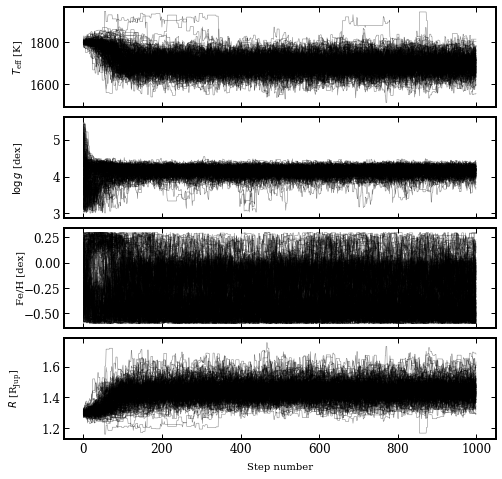

In [8]:
from IPython.display import Image
Image('walkers.png')

To be on the safe side, we remove the first 500 steps as burnin and use the remaining samples to plot the marginalized posterior distributions.

In [9]:
species.plot_posterior(tag='betapic',
                       burnin=500,
                       offset=(-0.25, -0.25),
                       limits=[(1500., 1920.), (3.4, 4.7), (-0.6, 0.3), (1.1, 1.8)],
                       output='posterior.png')

Median sample:
   - teff = 1695.05
   - logg = 4.16
   - feh = -0.37
   - radius = 1.44
   - distance = 19.75
Plotting the posterior: posterior.png... [DONE]


The temperature and radius are well constrained with the photometric data. Therefore, due to the prior on the mass, also the surface gravity is constrained. Constraining the metallicity would require more accurate data and/or larger wavelength coverage.

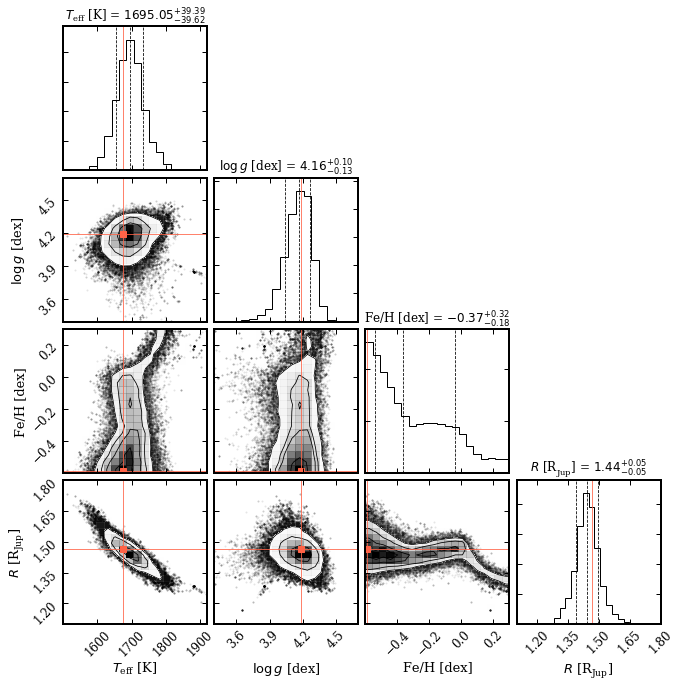

In [10]:
Image('posterior.png')

## Extracting boxes with results

We will now create `Box` objects with the results, which will be combined in a plot later on. We select 30 random samples from the posterior and use the parameters to interpolate the DRIFT-PHOENIX grid.

In [11]:
samples = database.get_mcmc_spectra(tag='betapic',
                                    burnin=500,
                                    random=30,
                                    wavel_range=(0.7, 6.5),
                                    spec_res=50.)

Getting MCMC spectra:   0%|          | 0/30 [00:00<?, ?it/s]

The smooth_spectrum function has not been fully tested. [WARNING]


Getting MCMC spectra: 100%|██████████| 30/30 [00:05<00:00,  5.51it/s]


We also extract the median values as the best-fit solution, again by excluding the first 500 steps.

In [12]:
median = database.get_median_sample(tag='betapic',
                                    burnin=500)

A best-fit spectrum is now extracted with the `ReadModel` functionalties.

In [13]:
read_model = species.ReadModel(model='drift-phoenix',
                               wavel_range=(0.7, 6.5))

In [14]:
modelbox = read_model.get_model(model_param=median,
                                spec_res=50.)

With the `ModelBox`, we interpolate the spectrum across a broader wavelength range and calculate the luminosity of the planet, which is added to the dictionary of the `parameters` attribute in the `ModelBox`.

In [15]:
modelbox = species.add_luminosity(modelbox)
modelbox.parameters

{'teff': 1695.0482600206046,
 'logg': 4.164876909524135,
 'feh': -0.36569875322006623,
 'radius': 1.4438540850964323,
 'distance': 19.75,
 'mass': 12.294788251306079,
 'luminosity': 0.00015062086580438917}

We also extract the photometric data of beta Pic b.

In [16]:
objectbox = database.get_object(object_name='beta Pic b',
                                filters=None,
                                inc_phot=True,
                                inc_spec=False)

Getting object: beta Pic b... [DONE]


And we compute the residuals, that is, the difference between the observed values and the median values from the MCMC.

In [17]:
residuals = species.get_residuals(datatype='model',
                                  spectrum='drift-phoenix',
                                  parameters=median,
                                  filters=None,
                                  objectbox=objectbox,
                                  inc_phot=True,
                                  inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals [sigma]:
   - Gemini/NICI.ED286: 0.66
   - LCO/VisAO.Ys: 0.69
   - Paranal/NACO.H: -0.33
   - Paranal/NACO.J: 0.26
   - Paranal/NACO.Ks: -0.40
   - Paranal/NACO.Lp: -2.12
   - Paranal/NACO.Mp: 0.04
   - Paranal/NACO.NB374: -0.45
   - Paranal/NACO.NB405: 1.54


Finally, we obtain all the synthetic photometry from the model spectra at the median parameter values.

In [18]:
synphot = species.multi_photometry(datatype='model',
                                   spectrum='drift-phoenix',
                                   filters=objectbox.filters,
                                   parameters=median)

Calculating synthetic photometry... [DONE]


## Plotting the SED and MCMC results

All the `Box` objects are now passed to the `plot_spectrum` function, together with the filer names and the residuals.

In [19]:
species.plot_spectrum(boxes=[samples, modelbox, objectbox, synphot],
                      filters=objectbox.filters,
                      residuals=residuals,
                      colors=('gray', 'tomato', ('black', None), 'black'),
                      xlim=(0.7, 6.0),
                      ylim=(-1.2e-15, 1.3e-14),
                      scale=('linear', 'linear'),
                      offset=(-0.25, -0.06),
                      output='spectrum.png')

Plotting spectrum: spectrum.png... [DONE]


Let's have a look at the result!

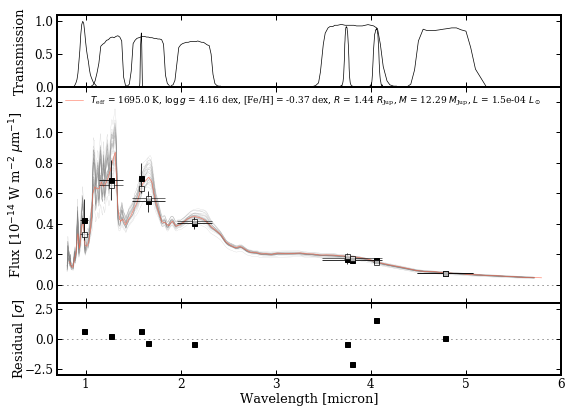

In [20]:
Image('spectrum.png')